In [199]:
import numpy as np
import pandas as pd

In [200]:
df = pd.read_csv('un.csv.1')

In [201]:
df.shape

(207, 14)

In [202]:
df.head()

,country,region,tfr,contraception,educationMale,educationFemale,lifeMale,lifeFemale,infantMortality,GDPperCapita,economicActivityMale,economicActivityFemale,illiteracyMale,illiteracyFemale
0,Afghanistan,Asia,6.90,NaN,NaN,NaN,45.0,46.0,154,2848,87.5,7.2,52.800,85.00
1,Albania,Europe,2.60,NaN,NaN,NaN,68.0,74.0,32,863,NaN,NaN,NaN,NaN
2,Algeria,Africa,3.81,52,11.1,9.9,67.5,70.3,44,1531,76.4,7.8,26.100,51.00
3,American.Samoa,Asia,NaN,NaN,NaN,NaN,68.0,73.0,11,NaN,58.8,42.4,0.264,0.36
4,Andorra,Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
df.count()

country                   207
region                    207
tfr                       197
contraception             144
educationMale              76
educationFemale            76
lifeMale                  196
lifeFemale                196
infantMortality           201
GDPperCapita              197
economicActivityMale      165
economicActivityFemale    165
illiteracyMale            160
illiteracyFemale          160
dtype: int64

In [204]:
type(df.count())

pandas.core.series.Series

In [205]:
df.count().sort_values(ascending=False)

region                    207
country                   207
infantMortality           201
GDPperCapita              197
tfr                       197
lifeFemale                196
lifeMale                  196
economicActivityFemale    165
economicActivityMale      165
illiteracyFemale          160
illiteracyMale            160
contraception             144
educationFemale            76
educationMale              76
dtype: int64

In [206]:
df.dtypes

country                    object
region                     object
tfr                       float64
contraception             float64
educationMale             float64
educationFemale           float64
lifeMale                  float64
lifeFemale                float64
infantMortality           float64
GDPperCapita              float64
economicActivityMale      float64
economicActivityFemale    float64
illiteracyMale            float64
illiteracyFemale          float64
dtype: object

In [207]:
from scipy.cluster.vq import vq, kmeans, whiten

clusters = []
k_range  = 10
whitened = whiten(df[['lifeMale', 'lifeFemale', 'infantMortality', 'GDPperCapita']].dropna())

for i in range(k_range):
    codebook, distortion = kmeans(whitened, i+1)
    clusters.append({ 'size': i+1, 'codebook': codebook, 'distortion': distortion })

In [208]:
clusters[2]

{'codebook': array([[ 7.55558256,  7.21575251,  0.19885574,  2.50972306],
        [ 6.88351434,  6.60912843,  0.71022647,  0.32563484],
        [ 5.16029451,  4.81697161,  2.44887162,  0.09508593]]),
 'distortion': 0.74652200200611341,
 'size': 3}

In [209]:
# Calculate the distance between each point and the centroids of each cluster.
features = df[['lifeMale', 'lifeFemale', 'infantMortality', 'GDPperCapita']].dropna()
features.shape

(188, 4)

In [210]:
import math

def distance_from_centroid(centroid):
    return lambda pt: math.sqrt(math.pow(centroid[0] - pt[0], 2) +
                                math.pow(centroid[1] - pt[1], 2) +
                                math.pow(centroid[2] - pt[2], 2) +
                                math.pow(centroid[3] - pt[3], 2))

# Probably want to use the whitened data to get meaningful results.
# Distances will be a M by k data frame.
for i in range(k_range):
    clusters[i]['distances'] = pd.DataFrame(index=features.index)
    for j in range(clusters[i]['size']):
        f = distance_from_centroid(clusters[i]['codebook'][j])
        # If I use features here instead of whitened,
        # they all cluster around the first centroid (for cluster 3)
        clusters[i]['distances']['d{}'.format(j+1)] = map(f, whitened)

In [211]:
clusters[2]['distances'].head()

,d1,d2,d3
0,6.092094,4.675246,1.764745
1,2.619362,0.275770,3.055562
2,2.741168,0.515817,2.666451
5,5.667586,4.080320,1.053990
7,1.727036,0.721522,3.538510


In [212]:
def get_closest(distances):
    return distances.idxmin()

def d_squared(distances):
    return math.pow(distances.min(), 2)
    
for i in range(k_range):
    try:
        clusters[i]['distances'].drop(labels=['closest'], inplace=True, axis=1)
    except ValueError:
        pass
    clusters[i]['distances']['closest'] = clusters[i]['distances'].apply(func=get_closest, axis=1)
    clusters[i]['distances']['d_squared'] = clusters[i]['distances'].apply(func=d_squared, axis=1)

In [213]:
clusters[2]['distances'].head()

,d1,d2,d3,closest,d_squared
0,6.092094,4.675246,1.764745,d3,3.114324
1,2.619362,0.275770,3.055562,d2,0.076049
2,2.741168,0.515817,2.666451,d2,0.266067
5,5.667586,4.080320,1.053990,d3,1.110895
7,1.727036,0.721522,3.538510,d2,0.520593


In [214]:
clusters[2]['distances'].pivot(columns='closest', values='d_squared').head()

closest,d1,d2,d3
0,NaN,NaN,3.114324
1,NaN,0.076049,NaN
2,NaN,0.266067,NaN
5,NaN,NaN,1.110895
7,NaN,0.520593,NaN


In [217]:
# Average within-cluster sum of squares (for cluster 3).
clusters[2]['distances'].pivot(columns='closest', values='d_squared').sum().mean()

46.811624155885795

In [218]:
# Calculate average within-cluster sum of squares for each centroid.
wcss_averages = []
for i in range(k_range):
    wcss_averages.append(clusters[i]['distances'].pivot(columns='closest', values='d_squared').sum().mean())

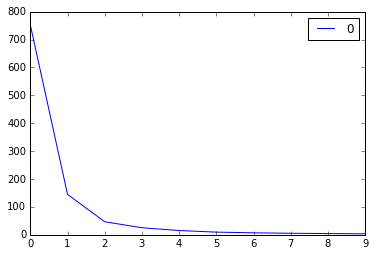

In [221]:
%matplotlib inline

pd.DataFrame(wcss_averages).plot()